# <u>Chapter 7</u>: Summarizing Wikipedia Articles

This exercise introduces another challenging topic in natural language processing and demystifies methods for `text summarization`. We delve into a state-of-the-art architecture that provides exceptional performance in many real-world applications. We also discuss the metrics to assess the performance of relevant systems.

In [1]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'wikipedia', 'rouge-score', 'spacy', 'textacy', 'networkx', 'matplotlib', 'tensorflow', 'numpy'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

<ins>Note</ins>: In case you get a _ReactorNotRestartable_ error, you have to restart the kernel. The reactor is only meant to run once.

## Abstractive summarization

`Abstractive summarization` aims to generate novel sentences by rephrasing the reference and introducing new words. As a widely accessible and free encyclopedia, `Wikipedia` contains information on all branches of knowledge, so it's a great resource for data. Thus, we extract data from Wikipedia and use it to train and evaluate a `transformer model`. Instead of implementing a crawler from scratch, we use a Python library that makes it easy to access and parse data from Wikipedia.

### Putting transformer into action

The following code requests the wiki page for _Athens_, the Greek capital, and prints the titles of the different sections.

In [2]:
import wikipedia

# Use the English language version.
wikipedia.set_lang("en")

# Get the wiki content for 'Athens'.
wikisearch = wikipedia.page("Athens")

# Print page sections.
wikisections = wikisearch.sections
print(wikisections)

['Etymology and names', 'History', 'Geography', 'Environment', 'Safety', 'Climate', 'Locations', 'Neighbourhoods of the center of Athens (Municipality of Athens)', 'Parks and zoos', 'Urban and suburban municipalities', 'Administration', 'Athens Urban Area', 'Athens Metropolitan Area', 'Demographics', 'Population in modern times', 'Population of the Athens Metropolitan Area', 'Population in ancient times', 'Government and politics', 'International relations and influence', 'Twin towns – sister cities', 'Partnerships', 'Other locations named after Athens', 'Economy', 'Transport', 'Bus transport', 'Athens Metro', 'Commuter/suburban rail (Proastiakos)', 'Tram', 'Athens International Airport', 'Railways and ferry connections', 'Motorways', 'Education', 'Culture', 'Archaeological hub', 'Architecture', 'Urban sculpture', 'Museums', 'Tourism', 'Entertainment and performing arts', 'Sports', 'Sports clubs', 'Olympic Games', '1896 Summer Olympics', '1906 Summer Olympics', '2004 Summer Olympics', 

Next, for our analysis, we download the wiki pages of forty capitals.

In [3]:
import pandas as pd

# Get the wiki page for the following capitals. 
capitals = [ 'Amsterdam', 'Ankara', 'Athens', 'Beijing', 'Canberra', 'Copenhagen', 'Dakar', 'Dhaka', 'Dublin',
            'Guatemala City', 'Harare', 'Islamabad', 'Jakarta', 'Jerusalem', 'Khartoum', 'Kinshasa', 'Kyiv',
            'Lisbon', 'London', 'Madrid', 'Manila', 'Mexico City', 'Montevideo', 'Moscow', 'Nairobi', 'New Delhi',
            'Ottawa', 'Paris', 'Riyadh', 'Rome', 'San Salvador', 'Seoul', 'Stockholm', 'Tehran', 'Tirana', 
            'Tokio', 'Washington D.C.', 'Wellington', 'Yerevan', 'Zagreb']

# Store specific information from each page.
df = pd.DataFrame(columns=['summary', 'content'])

# Iterate in the list of capitals and search for the corresponding wiki page.
for capital in capitals:
    wikisearch = wikipedia.page(capital)
    print("Read data from page: " + wikisearch.url)
    # We need to remove the summary from the content.
    df = df.append({'summary' : wikisearch.summary.replace("\n", " "), 
                    'content' : wikisearch.content.replace(wikisearch.summary, "").replace("\n", " ")}, 
                    ignore_index=True)

Read data from page: https://en.wikipedia.org/wiki/Amsterdam
Read data from page: https://en.wikipedia.org/wiki/Ankara
Read data from page: https://en.wikipedia.org/wiki/Athens
Read data from page: https://en.wikipedia.org/wiki/Beijing
Read data from page: https://en.wikipedia.org/wiki/Canberra
Read data from page: https://en.wikipedia.org/wiki/Copenhagen
Read data from page: https://en.wikipedia.org/wiki/Dhaka
Read data from page: https://en.wikipedia.org/wiki/Dhaka
Read data from page: https://en.wikipedia.org/wiki/Dublin
Read data from page: https://en.wikipedia.org/wiki/Guatemala_City
Read data from page: https://en.wikipedia.org/wiki/Harare
Read data from page: https://en.wikipedia.org/wiki/Islamabad
Read data from page: https://en.wikipedia.org/wiki/Jakarta
Read data from page: https://en.wikipedia.org/wiki/Jerusalem
Read data from page: https://en.wikipedia.org/wiki/Khartoum
Read data from page: https://en.wikipedia.org/wiki/Kinshasa
Read data from page: https://en.wikipedia.org

Before dealing with the transformer, let's examine the data by creating a method to extract triplets with the subject, verb, and object from the text.

In [4]:
import spacy
import textacy

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('sentencizer')

# Extract the subject, verb, and object from the text.
def extract_SVO(text):
    subjects, verbs, objects = [], [], []
    doc = nlp(text)

    # Get the tuples with the results.
    tuples = textacy.extract.subject_verb_object_triples(doc)

    # Iterate over all tuples.
    for x in tuples:

        subjects.append(str(x[0]).replace("[", "").replace("]", ""))
        verbs.append(str(x[1]).replace("[", "").replace("]", ""))
        objects.append(str(x[2]).replace("[", "").replace("]", ""))

    return subjects, verbs, objects

Next, we apply the method using _Athens_ as a case study and store the triplets for visualization.

In [5]:
# Obtain the triples for 'Athens'.
subjects, verbs, objects = extract_SVO(df['content'][2])

# Create the dataframe used for visualization.
kg_df = pd.DataFrame({"source": subjects, "edge": verbs, "target": objects})
kg_df.sample(3, random_state=123)

,source,edge,target
127,"banking, sector","is, represented","National, Bank, Alpha, Bank, Eurobank, Piraeus..."
187,neighbourhoods,include,Kypseli
24,this,sacked,Persians


In the following code, we generate the knowledge graph using only ``15`` relations for clarity.

{('Athens',
  'name'): Text(0.35237205318442355, -0.39061864357259923, "{'edge': 'took'}"),
 ('Athens',
  'destruction'): Text(0.31644300062629876, 0.3741833992243572, "{'edge': 'suffered'}"),
 ('Athens',
  'rebellion'): Text(0.37837608855799204, -0.20900187075524124, "{'edge': 'helped'}"),
 ('Athens',
  'Sparta'): Text(-0.2775837389876815, 0.38661933244698643, "{'edge': 'was, defeated'}"),
 ('Athens',
  'status'): Text(-0.09794284157821365, -0.429423074669864, "{'edge': 'was, given'}"),
 ('Athens',
  'settlement'): Text(-0.41439218596598976, 0.2146025540272936, "{'edge': 'expanded'}"),
 ('Athens',
  'Olympic, Games'): Text(0.12099669509981048, 0.4169748417821621, "{'edge': 'hosted'}"),
 ('Athens',
  'expansion'): Text(0.47436540636337954, -0.024929444563784067, "{'edge': 'experienced'}"),
 ('Athens',
  'Summer, Olympics'): Text(0.43110486670606835, 0.18926299795950569, "{'edge': 'hosted'}"),
 ('Athens',
  '89th'): Text(-0.49092685763170685, 0.008505055605424708, "{'edge': 'ranks'}"),


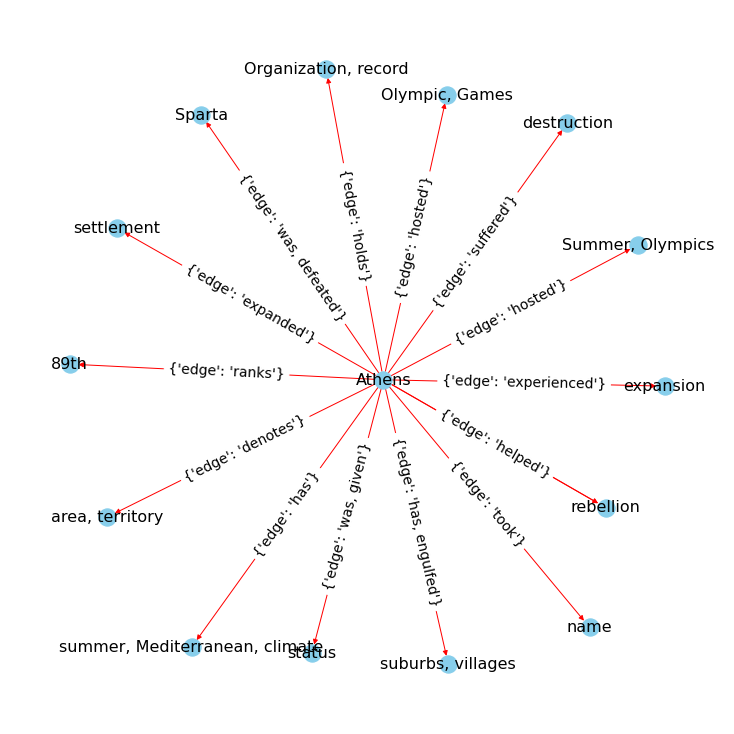

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Create a directed graph from a dataframe using 15 triples.
G = nx.from_pandas_edgelist(kg_df[kg_df['source'] == 'Athens'][0:15], 
                            "source", "target", edge_attr=True, 
                            create_using=nx.MultiDiGraph())

# Draw the graph.
#pd.set_option('display.max_colwidth', 200)
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, font_size=16, edge_color='r', pos=pos)
nx.draw_networkx_edge_labels(G, font_size=14, pos=pos)

_Athens_ is connected to all the other entities by an edge that represents the relationship between the two nodes.

### Training the model

Our training set consists of pairs of summaries and the full content for each capital city.

In [7]:
import re

# Extract the sentences from one of the summaries.
s = re.split('\. |\n', df['summary'][2])
summary_sentences =  pd.DataFrame(s, columns=['sentences'])
summary_sentences

,sentences
0,"Athens ( ATH-inz; Greek: Αθήνα, romanized: Ath..."
1,"With a population close to four million, it is..."
2,Athens dominates and is the capital of the Att...
3,"It was a centre for the arts, learning and phi..."
4,It is widely referred to as the cradle of West...
5,"In modern times, Athens is a large cosmopolita..."
6,"In 2021, Athens' urban area hosted more than t..."
7,"It also has a large financial sector, and its ..."
8,The Athens Urban Area or Greater Athens extend...
9,Athens is also the southernmost capital on the...


In [8]:
# Keep track of each document and its summary.
document = df['content']
summary = df['summary']

Add start and end tokens to summary since the target sequence is unknown for the test sequence. 

In [9]:
summary = summary.apply(lambda x: '<go> ' + x + ' <stop>')
summary.head()


0    <go> Amsterdam ( AM-stər-dam, UK also  AM-stər...
1    <go> Ankara ( ANG-kə-rə, US also  AHNG-kə-rə; ...
2    <go> Athens ( ATH-inz; Greek: Αθήνα, romanized...
3    <go> Beijing ( bay-JING; Chinese: 北京; pinyin: ...
4    <go> Canberra  ( (listen) KAN-b(ə-)rə) is the ...
Name: summary, dtype: object

Filter out the punctuation from the summary.

In [10]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

Create different tokenizers for document and summary.

In [11]:
import tensorflow as tf

document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

Fit text to tokenizer.

In [12]:
document_tokenizer.fit_on_texts(document)
summary_tokenizer.fit_on_texts(summary)

In [13]:
inputs = document_tokenizer.texts_to_sequences(document)
targets = summary_tokenizer.texts_to_sequences(summary)

In [14]:
encoder_vocab_size = len(document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(30419, 3500)

In [15]:
document_lengths = pd.Series([len(x) for x in document])
summary_lengths = pd.Series([len(x) for x in summary])

In [16]:
encoder_maxlen = 500
decoder_maxlen = 50

In [17]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

In [18]:
inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

In [19]:
# Based on the system capabilities, we can experiment with different values.
BUFFER_SIZE = 20000
BATCH_SIZE = 8

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [21]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [22]:
import numpy as np

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # Apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [23]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [24]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [25]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

In [27]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

Create the encoder layer.

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

Create the decoder layer.

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

Create the class for the encoder.

In [30]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

Create the class for the decoder.

In [31]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

Create the class for the transformer.

In [32]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

Set the hyperparameter values.

In [33]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
EPOCHS = 200

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Next, we can create the _learning_rate_ and the _Adam_ optimizer that uses it.

In [35]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

For calculating loss, we incorporate ``SparseCategoricalCrossentropy`` that computes the cross-entropy loss between the labels and predictions, suitable when the output labels are integer values.

In [36]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [37]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [38]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [39]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=encoder_vocab_size, 
    pe_target=decoder_vocab_size,
)

In [40]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

The training runs can take several hours or even days to conclude, so we need a way to keep track of the progress and resume the process in case of a failure without the need to start from scratch. 

A useful feature, in this case, is the ``Checkpoint`` mechanism.

In [41]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    

In [42]:
#@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
         
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [43]:
import time

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        # Uncomment the following lines to show more training results.  
        # if batch % 429 == 0:
        # print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))

    # Uncomment the following lines to save the checkpoints.  
    # if (epoch + 1) % 5 == 0:
    #     ckpt_save_path = ckpt_manager.save()
    #     print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Loss 8.1599
Time taken for 1 epoch: 3.6703853607177734 secs

Epoch 2 Loss 8.1588
Time taken for 1 epoch: 2.026690721511841 secs

Epoch 3 Loss 8.1438
Time taken for 1 epoch: 1.9850139617919922 secs

Epoch 4 Loss 8.1252
Time taken for 1 epoch: 1.9886560440063477 secs

Epoch 5 Loss 8.1063
Time taken for 1 epoch: 2.066765308380127 secs

Epoch 6 Loss 8.0734
Time taken for 1 epoch: 2.085481643676758 secs

Epoch 7 Loss 8.0463
Time taken for 1 epoch: 2.0824904441833496 secs

Epoch 8 Loss 8.0144
Time taken for 1 epoch: 2.096574544906616 secs

Epoch 9 Loss 7.9819
Time taken for 1 epoch: 2.031087636947632 secs

Epoch 10 Loss 7.9493
Time taken for 1 epoch: 2.141810178756714 secs

Epoch 11 Loss 7.9194
Time taken for 1 epoch: 2.175393581390381 secs

Epoch 12 Loss 7.8900
Time taken for 1 epoch: 2.388427495956421 secs

Epoch 13 Loss 7.8577
Time taken for 1 epoch: 2.670711040496826 secs

Epoch 14 Loss 7.8276
Time taken for 1 epoch: 2.6833577156066895 secs

Epoch 15 Loss 7.8014
Time taken for 1 

Use the model for inference.

In [44]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["<go>"]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["<stop>"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

## Summarization performance

The `Recall-Oriented Understudy for Gisting Evaluation` (ROUGE) score is the subject of the current section, and although its name sounds complicated, it's incredibly easy to understand and implement. It works by comparing an automatically produced summary against a human reference summary using n-grams. 

In [45]:
# Summarize an input document.
def summarize(input_document):

    summarized = evaluate(input_document=input_document)[0].numpy()
    # Exclude <go> token.
    summarized = np.expand_dims(summarized[1:], 0)

    return summary_tokenizer.sequences_to_texts(summarized)[0]

Next, we call the method for one sample from the documents.

In [46]:
result = summarize(document[2])
print(result)

athens ath inz greek αθήνα romanized athína aˈθina listen ancient greek ἀθῆναι romanized athênai pl atʰɛ̂ːnai̯ is both the capital and largest city of greece with a population close to four million it is also the seventh largest city in the european union athens dominates and is the capital and


The reference in this case is:

In [47]:
reference = ' '.join(summary[2].split()[1:51]).lower()
print(reference)

athens ( ath-inz; greek: αθήνα, romanized: athína [aˈθina] (listen); ancient greek: ἀθῆναι, romanized: athênai (pl.) [atʰɛ̂ːnai̯]) is both the capital and largest city of greece. with a population close to four million, it is also the seventh largest city in the european union. athens dominates and is the capital of


Finally, the scores are calculated as follows:

In [48]:
from rouge_score import rouge_scorer

# Calculate the Rouge scores.
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(result, reference)
print(scores)

{'rouge1': Score(precision=0.9807692307692307, recall=0.9807692307692307, fmeasure=0.9807692307692307), 'rouge2': Score(precision=0.9803921568627451, recall=0.9803921568627451, fmeasure=0.9803921568627451), 'rougeL': Score(precision=0.9807692307692307, recall=0.9807692307692307, fmeasure=0.9807692307692307)}


## What we have learned …

| | | |
| --- | --- | --- |
| **Visualizations**<ul><li>Knowledge graph</li></ul> | **ML concepts**<ul><li>Attention</li></ul> | **ML algorithms & models** <ul><li>Transformer</li></ul> |
| **Performance**<ul><li>ROUGE</li></ul>| | |
| | | |